In [25]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import requests
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from PIL import Image

from kaggle.api.kaggle_api_extended import KaggleApi

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50, EfficientNetB0, InceptionV3, MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import check_random_state

from mpl_toolkits.mplot3d import Axes3D

print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Available Devices: ", tf.config.list_physical_devices())

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Pull Dataset from Kaggle

#### mac

In [ ]:
"""# Read API key from config.txt
config_file = "../config.txt"
with open(config_file, "r") as file:
    data = file.read()

# Extract API key JSON
api_key = data.split("KAGGLE_API_KEY=")[1].strip()
api_key_json = json.loads(api_key)

# Save the API key to ~/.kaggle/kaggle.json
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)
with open(os.path.join(kaggle_dir, "kaggle.json"), "w") as json_file:
    json.dump(api_key_json, json_file)

# Set correct permissions
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

# Define the dataset identifier
dataset_identifier = "andrewmquintana/sf-bay-backyard-animals"  # Replace with the actual dataset identifier

# Download the dataset
destination_folder = "../data"  # Replace with your desired folder
os.makedirs(destination_folder, exist_ok=True)

print("Downloading dataset...")
api.dataset_download_files(dataset_identifier, path=destination_folder, unzip=True)
print(f"Dataset downloaded and extracted to '{destination_folder}'")"""

Dataset URL: https://www.kaggle.com/datasets/andrewmquintana/sf-bay-backyard-animals
Dataset downloaded and extracted to '../data'


#### Colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

file_path = '/content/drive/MyDrive/bird_sensor/kaggle.json'

if not os.path.exists(file_path):
  print(f"File '{file_path}' not found. Please upload it.")
  uploaded = files.upload()
  for filename in uploaded.keys():
    if filename == 'kaggle.json':  # Check if uploaded file is 'kaggle.json'
      # Move the uploaded file to the desired location in Google Drive
      # Use shutil.move to move the file (renames if the destination exists)
      shutil.move(filename, file_path)
      print(f'Uploaded and moved {filename} to {file_path}')
      break  # Stop after processing 'kaggle.json'
    else:
      print(f"Uploaded file '{filename}' is not 'kaggle.json'. Please upload the correct file.")
else:
  print(f"File '{file_path}' already exists. Skipping upload.")

# Set up the Kaggle API configuration
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/bird_sensor/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 2: Download the dataset
# Replace 'your-kaggle-dataset-name' with the specific dataset name from Kaggle
!kaggle datasets download -d sf-bay-backyard-animals

# Step 3: Unzip the dataset
!unzip sf-bay-backyard-animals -d dataset

Mounted at /content/drive
File '/content/drive/MyDrive/bird_sensor/kaggle.json' already exists. Skipping upload.
Dataset URL: https://www.kaggle.com/datasets/andrewmquintana/sf-bay-backyard-animals
License(s): unknown
100% 801M/802M [00:40<00:00, 24.0MB/s]
100% 802M/802M [00:40<00:00, 20.8MB/s]
Archive:  sf-bay-backyard-animals.zip
  inflating: dataset/sf_bay_backyard_animals/american_crow/american_crow_0000.jpg  
  inflating: dataset/sf_bay_backyard_animals/american_crow/american_crow_0001.jpg  
  inflating: dataset/sf_bay_backyard_animals/american_crow/american_crow_0002.jpg  
  inflating: dataset/sf_bay_backyard_animals/american_crow/american_crow_0003.jpg  
  inflating: dataset/sf_bay_backyard_animals/american_crow/american_crow_0004.jpg  
  inflating: dataset/sf_bay_backyard_animals/american_crow/american_crow_0005.jpg  
  inflating: dataset/sf_bay_backyard_animals/american_crow/american_crow_0006.jpg  
  inflating: dataset/sf_bay_backyard_animals/american_crow/american_crow_0007.

## 2. Train a Deep Learning Classification Model (CNN)

### Data Preparation

In [5]:
# Path to your dataset directory
data_dir = 'dataset/sf_bay_backyard_animals'

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)  # Attempt to open the file as an image
            img.verify()  # Verify it's a valid image
        except (IOError, SyntaxError):
            print(f"Removing invalid image: {file_path}")
            os.remove(file_path)  # Remove invalid files

# Create a DataFrame with file paths and labels
filepaths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            filepaths.append(os.path.join(class_dir, filename))
            labels.append(class_name)

# Create a DataFrame
data = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

# Display the first few rows
print(data.head())

                                            filepath         label
0  dataset/sf_bay_backyard_animals/oak_titmouse/o...  oak_titmouse
1  dataset/sf_bay_backyard_animals/oak_titmouse/o...  oak_titmouse
2  dataset/sf_bay_backyard_animals/oak_titmouse/o...  oak_titmouse
3  dataset/sf_bay_backyard_animals/oak_titmouse/o...  oak_titmouse
4  dataset/sf_bay_backyard_animals/oak_titmouse/o...  oak_titmouse


In [6]:
# Split the data into train (70%) and temp (30%)
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)

# Further split temp into validation (20%) and test (10%)
val_data, test_data = train_test_split(temp_data, test_size=0.333, stratify=temp_data['label'], random_state=42)

# Print the sizes of each split
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 2100
Validation samples: 600
Test samples: 300


In [7]:
# Create ImageDataGenerator instances
input_shape = (128, 128, 3)
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical'
)

# Validation generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='filepath',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical'
)

# Test generator
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order for testing
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Found 2100 validated image filenames belonging to 12 classes.
Found 600 validated image filenames belonging to 12 classes.
Found 300 validated image filenames belonging to 12 classes.
Number of classes: 12


## Deep Learning - Transfer Learning & Hyperparameter Tuning

In [11]:
# Set initial hyperparameters
initial_learning_rate = 1e-3
dropout_rate = 0.5
epochs_initial = 5
input_shape = (128, 128, 3)

# Performance tracking
training_times = {}
peak_accuracy = {}

def plot_model_performance(history_output, model_name):

  # Plot training & validation accuracy
  plt.figure()
  plt.plot(history_output.history['accuracy'], label='Train Accuracy')
  plt.plot(history_output.history['val_accuracy'], label='Val Accuracy')
  plt.title(f'Model Accuracy (Initial Training) for {model_name}')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Plot training & validation loss
  plt.figure()
  plt.plot(history_output.history['loss'], label='Train Loss')
  plt.plot(history_output.history['val_loss'], label='Val Loss')
  plt.title(f'Model Loss (Initial Training) for {model_name}')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

# Plot training time comparison
def plot_training_times(training_times):
    model_names = list(training_times.keys())
    times = list(training_times.values())

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, times, color='skyblue')
    plt.title('Training Time Comparison', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Training Time (seconds)', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot peak performance bar graph
def plot_peak_accuracy(peak_performance):
    model_names = list(peak_performance.keys())
    accuracies = list(peak_performance.values())

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color='lightgreen')
    plt.title('Peak Validation Accuracy Comparison', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Peak Validation Accuracy', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Model Comparison
1.	Basic CNN: Being a common type of model used for classification, this will be used to establish a baseline performance for this application, allowing for a direct comparison with more complex models and understanding the need for advanced architectures.
2.	ResNet50: With its residual connections, addresses vanishing gradient issues in deep networks and is well-suited for extracting hierarchical features in datasets with complex patterns. If hierarchical features can be established in the birds, this would be a great setup, however, it may not be the best for an initial 4 set of classes.
3.	EfficientNetB0: Balances accuracy and computational efficiency, making it a strong candidate for applications where both performance and resource constraints must be optimized. When I'm retraining for new classes, as they're observed, I don't want the training to take too long.
4.	MobileNetV2: With its lightweight architecture, is ideal for applications requiring high-speed inference and is particularly effective for feature extraction in transfer learning scenarios. The feature extraction ability should make this very effective for the classification of these animals.

Training Basic CNN...
Epoch 1/5


2024-12-06 19:54:28.980644: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


29/29 [==============================] - 20s 563ms/step - loss: 3.4260 - accuracy: 0.1071 - val_loss: 2.4559 - val_accuracy: 0.2061
Epoch 2/5
29/29 [==============================] - 16s 555ms/step - loss: 2.2679 - accuracy: 0.2546 - val_loss: 2.1362 - val_accuracy: 0.3282
Epoch 3/5
29/29 [==============================] - 16s 562ms/step - loss: 1.8810 - accuracy: 0.4109 - val_loss: 1.8685 - val_accuracy: 0.4275
Epoch 4/5
29/29 [==============================] - 15s 520ms/step - loss: 1.4710 - accuracy: 0.5814 - val_loss: 1.7941 - val_accuracy: 0.4542
Epoch 5/5
29/29 [==============================] - 14s 478ms/step - loss: 1.2014 - accuracy: 0.6459 - val_loss: 1.7179 - val_accuracy: 0.4924


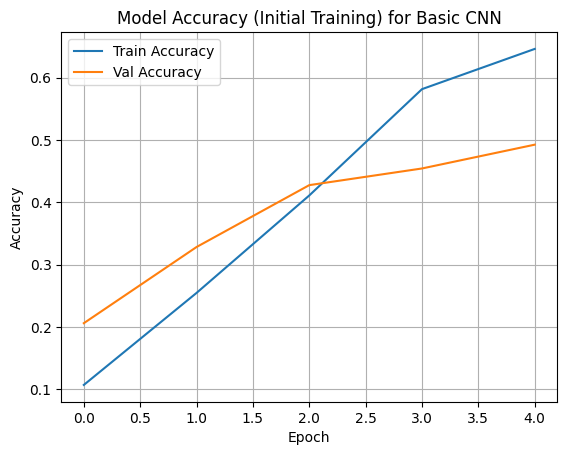

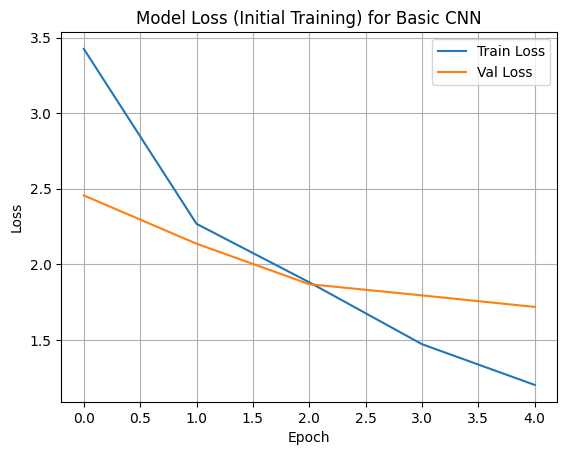

Training ResNet50...
Epoch 1/5
29/29 [==============================] - 20s 579ms/step - loss: 3.2435 - accuracy: 0.1279 - val_loss: 4.1821 - val_accuracy: 0.0763
Epoch 2/5
29/29 [==============================] - 19s 670ms/step - loss: 2.5340 - accuracy: 0.2284 - val_loss: 3.9853 - val_accuracy: 0.0954
Epoch 3/5
29/29 [==============================] - 19s 657ms/step - loss: 2.1891 - accuracy: 0.2995 - val_loss: 4.3689 - val_accuracy: 0.0725
Epoch 4/5
29/29 [==============================] - 20s 679ms/step - loss: 2.0190 - accuracy: 0.3650 - val_loss: 5.1610 - val_accuracy: 0.0802
Epoch 5/5
29/29 [==============================] - 20s 690ms/step - loss: 1.8161 - accuracy: 0.4022 - val_loss: 4.2856 - val_accuracy: 0.1145


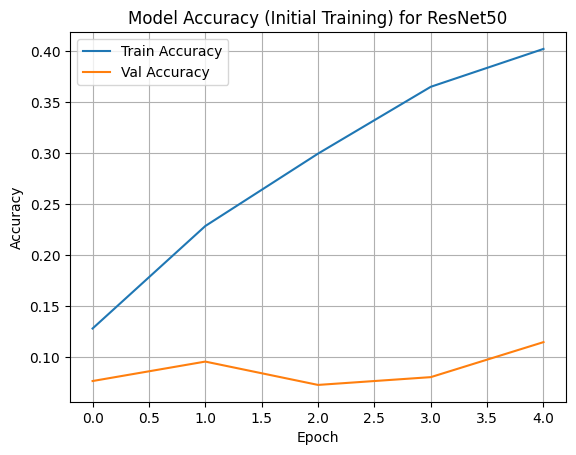

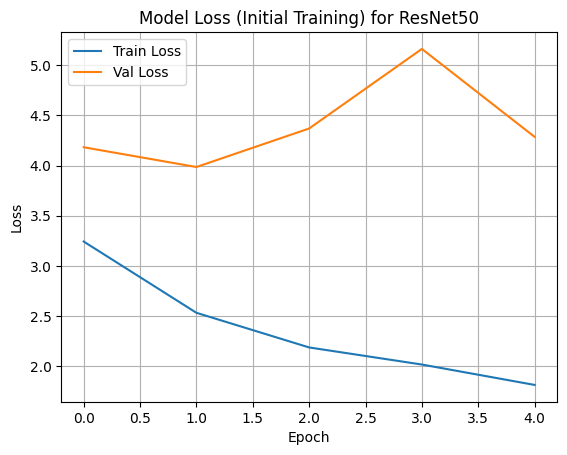

Training EfficientNetB0...
Epoch 1/5
29/29 [==============================] - 26s 648ms/step - loss: 2.7307 - accuracy: 0.1432 - val_loss: 9.7147 - val_accuracy: 0.0725
Epoch 2/5
29/29 [==============================] - 14s 504ms/step - loss: 2.5419 - accuracy: 0.2011 - val_loss: 9.2938 - val_accuracy: 0.0916
Epoch 3/5
29/29 [==============================] - 17s 596ms/step - loss: 2.4076 - accuracy: 0.2306 - val_loss: 15.1099 - val_accuracy: 0.0763
Epoch 4/5
29/29 [==============================] - 15s 525ms/step - loss: 2.3139 - accuracy: 0.2470 - val_loss: 13.6878 - val_accuracy: 0.0840
Epoch 5/5
29/29 [==============================] - 15s 532ms/step - loss: 2.3038 - accuracy: 0.2514 - val_loss: 20.8949 - val_accuracy: 0.0916


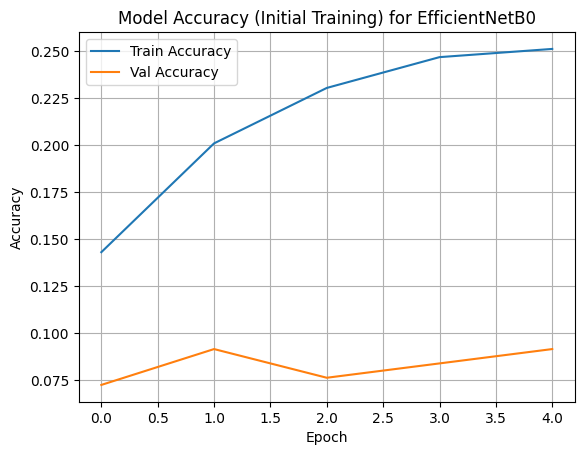

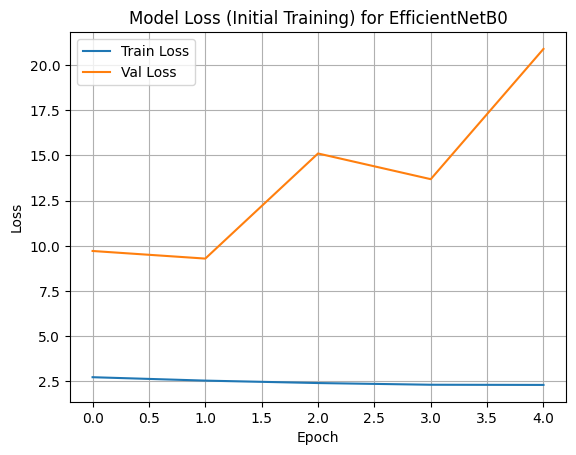

Training MobileNetV2...
Epoch 1/5
29/29 [==============================] - 21s 633ms/step - loss: 1.1619 - accuracy: 0.6612 - val_loss: 1.5266 - val_accuracy: 0.7214
Epoch 2/5
29/29 [==============================] - 16s 542ms/step - loss: 0.3450 - accuracy: 0.8973 - val_loss: 0.7810 - val_accuracy: 0.7824
Epoch 3/5
29/29 [==============================] - 15s 510ms/step - loss: 0.1966 - accuracy: 0.9541 - val_loss: 0.5628 - val_accuracy: 0.8473
Epoch 4/5
29/29 [==============================] - 15s 505ms/step - loss: 0.1230 - accuracy: 0.9727 - val_loss: 0.5163 - val_accuracy: 0.8473
Epoch 5/5
29/29 [==============================] - 17s 596ms/step - loss: 0.0928 - accuracy: 0.9825 - val_loss: 0.4687 - val_accuracy: 0.8626


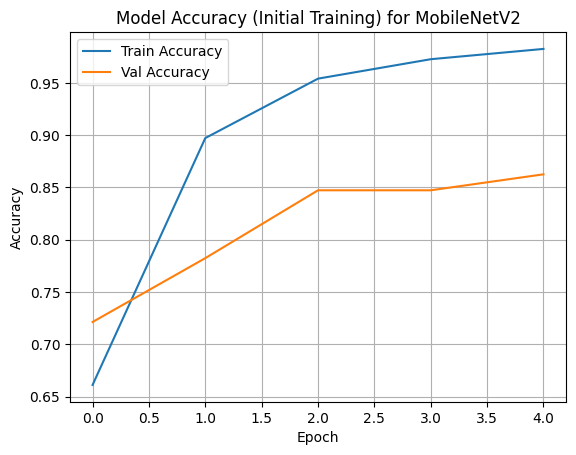

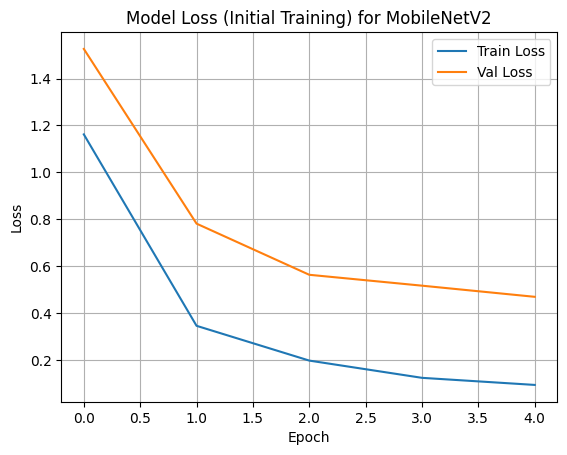

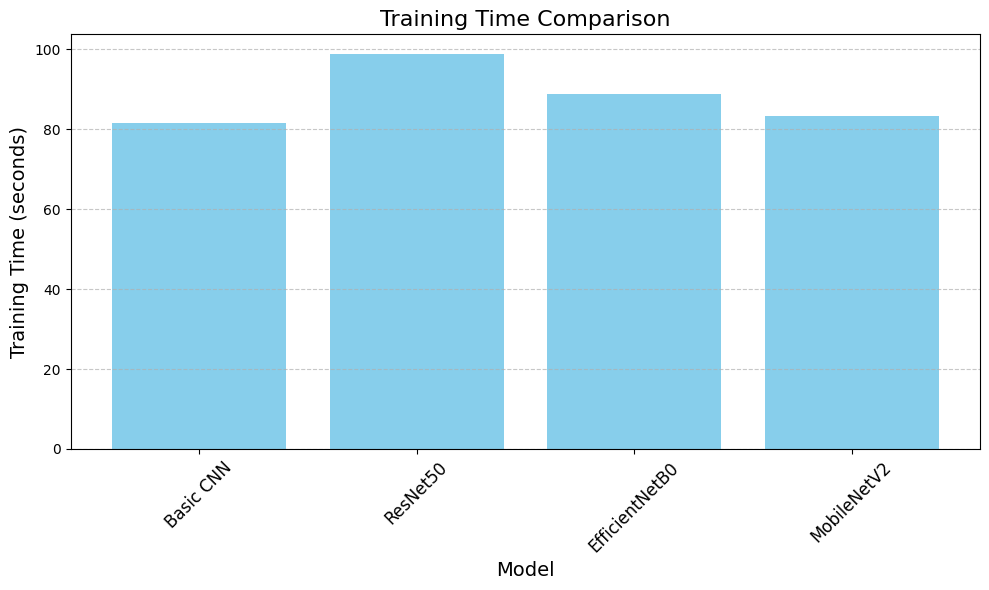

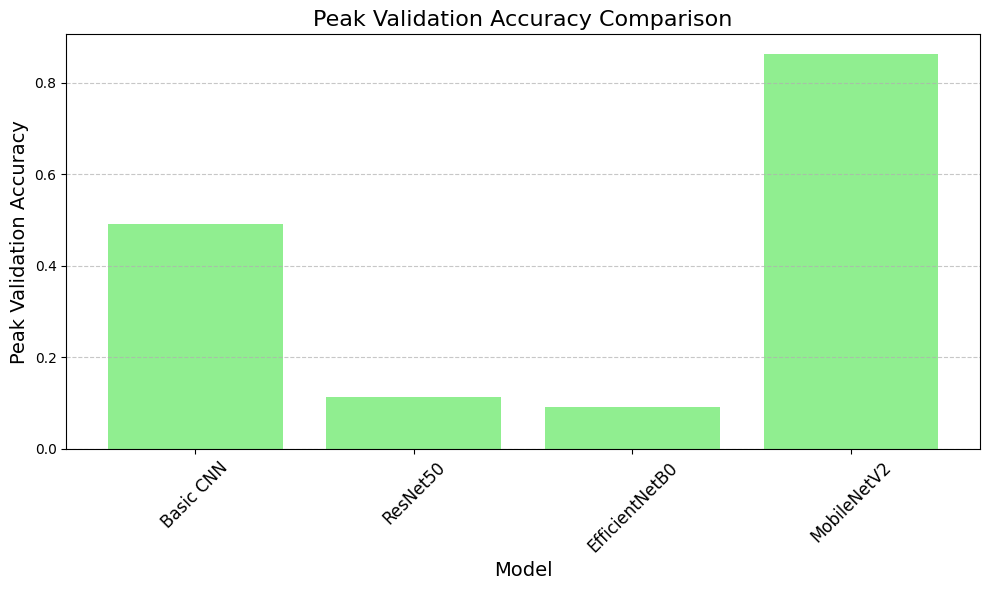

In [ ]:
# Create a basic CNN
def build_basic_cnn():
    global input_shape, num_classes
    model = Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
      MaxPooling2D((2, 2)),
      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(dropout_rate),
      Dense(num_classes, activation='softmax')
    ])
    return model

# Pre-trained models
def build_transfer_learning_model(base_model_class, include_top=False):
    global input_shape, num_classes
    base_model = base_model_class(weights='imagenet', include_top=include_top, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# Train and evaluate models
def train_and_evaluate_model(model, model_name):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(train_generator, epochs=epochs_initial, validation_data=validation_generator, verbose=1)
    end_time = time.time()

    # Record peak validation accuracy
    peak_accuracy[model_name] = max(history.history['val_accuracy'])

    # Record traning time
    training_time = end_time - start_time
    training_times[model_name] = training_time

    plot_model_performance(history, model_name)

# Main loop to test all models
models = {
    "Basic CNN": build_basic_cnn(),
    "ResNet50": build_transfer_learning_model(ResNet50),
    "EfficientNetB0": build_transfer_learning_model(EfficientNetB0),
    "MobileNetV2": build_transfer_learning_model(MobileNetV2),
}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    train_and_evaluate_model(model, model_name)

# Plot the performance
plot_training_times(training_times)
plot_peak_accuracy(peak_accuracy)

### Freeze Early Layers and Iterate to Determine Baseline
With MobileNetV2 performing incredibly well, reaching 88% validation accuracy and 100% training accuracy, this is going to be the model used moving forward.

#### Reducing Complexity via Layer Density
The strong accuracy was paired with significant overfitting. To address this, the layer density will be reduced to reduce complexity of the architecture.

Epoch 1/5
29/29 [==============================] - 18s 578ms/step - loss: 1.4477 - accuracy: 0.5508 - val_loss: 1.5779 - val_accuracy: 0.7099
Epoch 2/5
29/29 [==============================] - 15s 514ms/step - loss: 0.6020 - accuracy: 0.8339 - val_loss: 0.7983 - val_accuracy: 0.7672
Epoch 3/5
29/29 [==============================] - 14s 484ms/step - loss: 0.3978 - accuracy: 0.9060 - val_loss: 0.7194 - val_accuracy: 0.7863
Epoch 4/5
29/29 [==============================] - 14s 503ms/step - loss: 0.2999 - accuracy: 0.9366 - val_loss: 0.5012 - val_accuracy: 0.8511
Epoch 5/5
29/29 [==============================] - 15s 537ms/step - loss: 0.2450 - accuracy: 0.9443 - val_loss: 0.5187 - val_accuracy: 0.8359


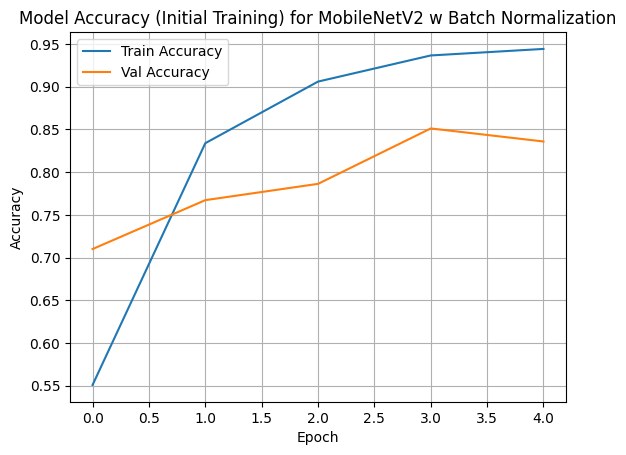

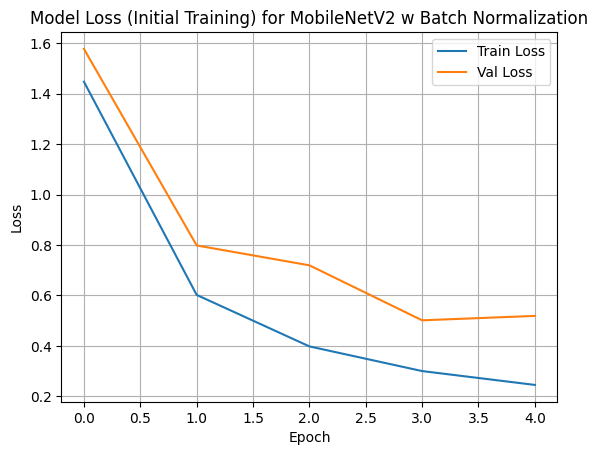

In [ ]:

# Load MobileNetV2 with pre-trained weights
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers initially
model.trainable = False

# Build the transfer learning model
inputs = Input(shape=input_shape)
x = model(inputs, training=False)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Initial training with frozen base
iteration_history = model.fit(
    train_generator,
    epochs=epochs_initial,
    validation_data=validation_generator
)

# Plot model's performance
plot_model_performance(iteration_history, "MobileNetV2 w Batch Normalization")

#### Further Reduction in Complexity via Layer Density
With the strong performance, reducing layer density further to see if performance improves, again.

Epoch 1/5
29/29 [==============================] - 18s 555ms/step - loss: 1.6812 - accuracy: 0.4896 - val_loss: 1.1335 - val_accuracy: 0.7099
Epoch 2/5
29/29 [==============================] - 15s 531ms/step - loss: 0.8668 - accuracy: 0.7617 - val_loss: 0.6081 - val_accuracy: 0.8435
Epoch 3/5
29/29 [==============================] - 16s 559ms/step - loss: 0.6267 - accuracy: 0.8546 - val_loss: 0.6070 - val_accuracy: 0.8435
Epoch 4/5
29/29 [==============================] - 13s 442ms/step - loss: 0.4729 - accuracy: 0.9027 - val_loss: 0.5325 - val_accuracy: 0.8626
Epoch 5/5
29/29 [==============================] - 11s 395ms/step - loss: 0.3895 - accuracy: 0.9322 - val_loss: 0.5149 - val_accuracy: 0.8550


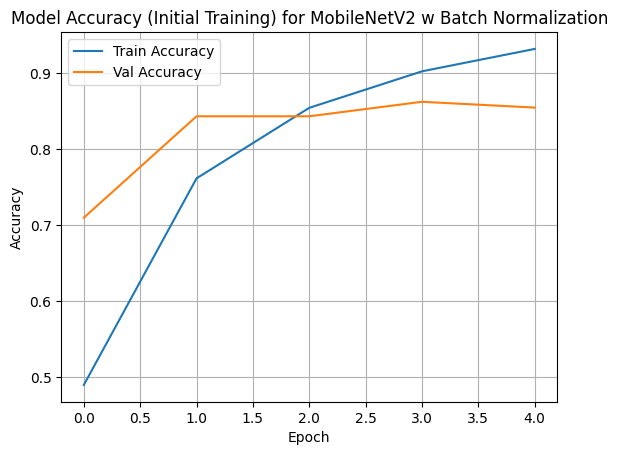

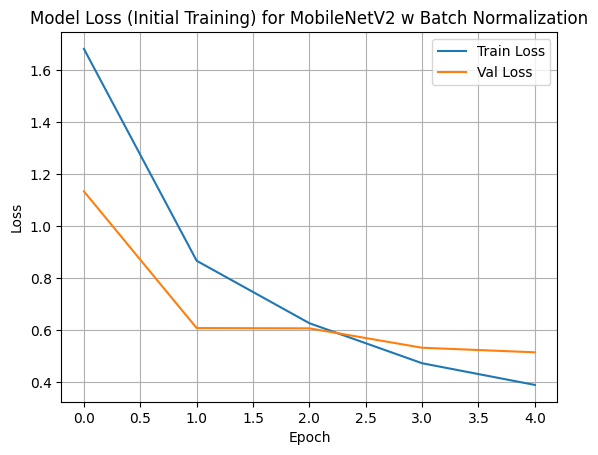

In [ ]:

# Load MobileNetV2 with pre-trained weights
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers initially
model.trainable = False

# Build the transfer learning model
inputs = Input(shape=input_shape)
x = model(inputs, training=False)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Initial training with frozen base
iteration_history = model.fit(
    train_generator,
    epochs=epochs_initial,
    validation_data=validation_generator
)

# Plot model's performance
plot_model_performance(iteration_history, "MobileNetV2 w Batch Normalization")

#### Adding Complexity via Layer Depth
Adding a layer to with the maximum being the previous density may help improve the performance while indicating whether or not a deeper architecture will improve performance.

Epoch 1/5
29/29 [==============================] - 15s 461ms/step - loss: 2.3901 - accuracy: 0.2415 - val_loss: 3.3263 - val_accuracy: 0.3855
Epoch 2/5
29/29 [==============================] - 12s 412ms/step - loss: 2.0593 - accuracy: 0.2984 - val_loss: 1.4724 - val_accuracy: 0.5305
Epoch 3/5
29/29 [==============================] - 12s 403ms/step - loss: 1.8002 - accuracy: 0.4066 - val_loss: 1.3334 - val_accuracy: 0.5153
Epoch 4/5
29/29 [==============================] - 12s 404ms/step - loss: 1.7153 - accuracy: 0.4448 - val_loss: 1.1894 - val_accuracy: 0.6527
Epoch 5/5
29/29 [==============================] - 12s 436ms/step - loss: 1.5372 - accuracy: 0.4984 - val_loss: 1.0815 - val_accuracy: 0.7252


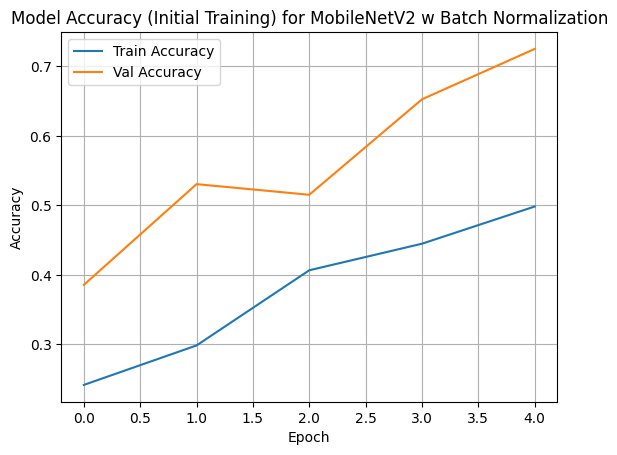

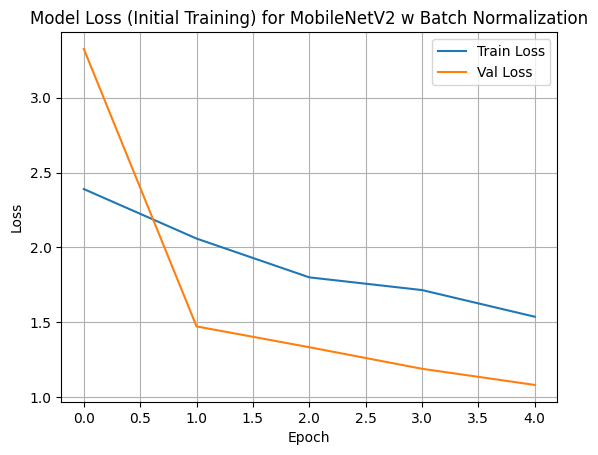

In [ ]:

# Load MobileNetV2 with pre-trained weights
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers initially
model.trainable = False

# Build the transfer learning model
inputs = Input(shape=input_shape)
x = model(inputs, training=False)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Initial training with frozen base
iteration_history = model.fit(
    train_generator,
    epochs=epochs_initial,
    validation_data=validation_generator
)

# Plot model's performance
plot_model_performance(iteration_history, "MobileNetV2 w Batch Normalization")

Epoch 1/5
29/29 [==============================] - 16s 476ms/step - loss: 1.2901 - accuracy: 0.6514 - val_loss: 1.4653 - val_accuracy: 0.7786
Epoch 2/5
29/29 [==============================] - 13s 433ms/step - loss: 0.2235 - accuracy: 0.9268 - val_loss: 0.6890 - val_accuracy: 0.8473
Epoch 3/5
29/29 [==============================] - 13s 457ms/step - loss: 0.1315 - accuracy: 0.9607 - val_loss: 0.5727 - val_accuracy: 0.8588
Epoch 4/5
29/29 [==============================] - 15s 507ms/step - loss: 0.0782 - accuracy: 0.9869 - val_loss: 0.5334 - val_accuracy: 0.8664
Epoch 5/5
29/29 [==============================] - 13s 441ms/step - loss: 0.0522 - accuracy: 0.9902 - val_loss: 0.5239 - val_accuracy: 0.8702


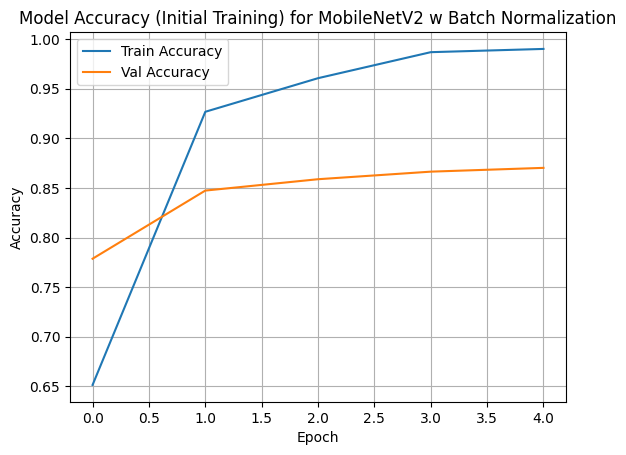

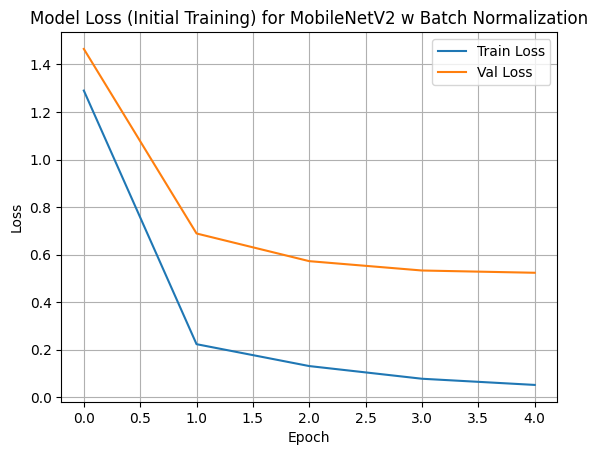

In [ ]:

# Load MobileNetV2 with pre-trained weights
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers initially
model.trainable = False

# Build the transfer learning model
inputs = Input(shape=input_shape)
x = model(inputs, training=False)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Initial training with frozen base
iteration_history = model.fit(
    train_generator,
    epochs=epochs_initial,
    validation_data=validation_generator
)

# Plot model's performance
plot_model_performance(iteration_history, "MobileNetV2 w Batch Normalization")

### Unfreeze Layers and Fine Tuning

#### Ideal Base Model Training

#### Fine Tuning

Fine-tuning with layers unfrozen starting at 25...
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 95s 838ms/step - accuracy: 0.2946 - loss: 2.6595 - val_accuracy: 0.6733 - val_loss: 1.1751 - learning_rate: 1.0000e-04
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 602ms/step - accuracy: 0.8437 - loss: 0.5237 - val_accuracy: 0.7383 - val_loss: 0.8615 - learning_rate: 1.0000e-04
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 606ms/step - accuracy: 0.9303 - loss: 0.2461 - val_accuracy: 0.7567 - val_loss: 0.7765 - learning_rate: 1.0000e-04
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 81s 587ms/step - accuracy: 0.9517 - loss: 0.1842 - val_accuracy: 0.7617 - val_loss: 0.7149 - learning_rate: 1.0000e-04
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 607ms/step - accuracy: 0.9756 - loss: 0.1027 - val_accuracy: 0.8067 - val_loss: 0.5824 - learning_rate: 1.0000e-04


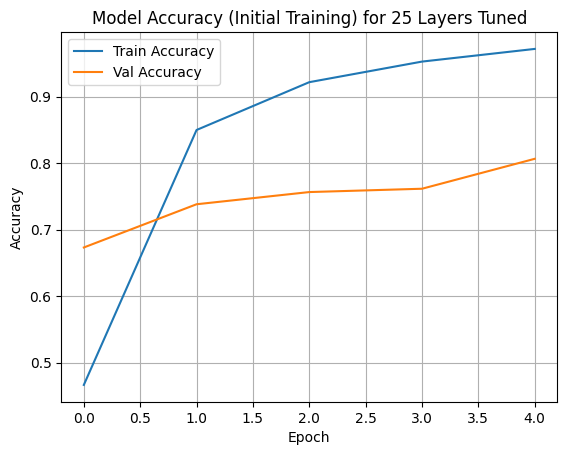

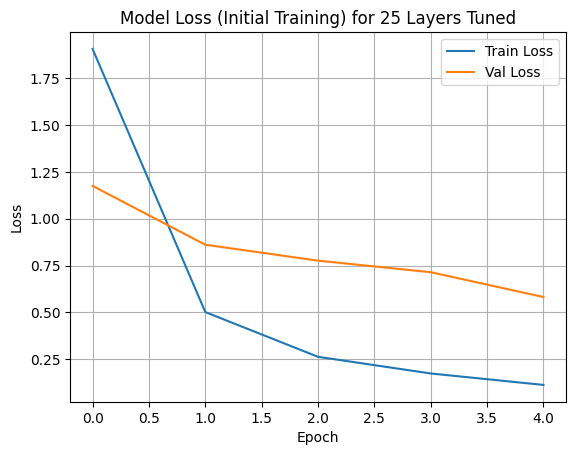

Test Accuracy: 0.81, Test Loss: 0.58
Fine-tuning with layers unfrozen starting at 50...
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 841ms/step - accuracy: 0.2850 - loss: 2.7181 - val_accuracy: 0.6733 - val_loss: 0.9751 - learning_rate: 1.0000e-04
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 579ms/step - accuracy: 0.8331 - loss: 0.5534 - val_accuracy: 0.7383 - val_loss: 0.8125 - learning_rate: 1.0000e-04
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 608ms/step - accuracy: 0.9136 - loss: 0.2938 - val_accuracy: 0.7783 - val_loss: 0.6993 - learning_rate: 1.0000e-04
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 596ms/step - accuracy: 0.9682 - loss: 0.1586 - val_accuracy: 0.7933 - val_loss: 0.5765 - learning_rate: 1.0000e-04
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 584ms/step - accuracy: 0.9852 - loss: 0.0953 - val_accuracy: 0.8433 - val_loss: 0.4757 - learning_rate: 1.0000e-04


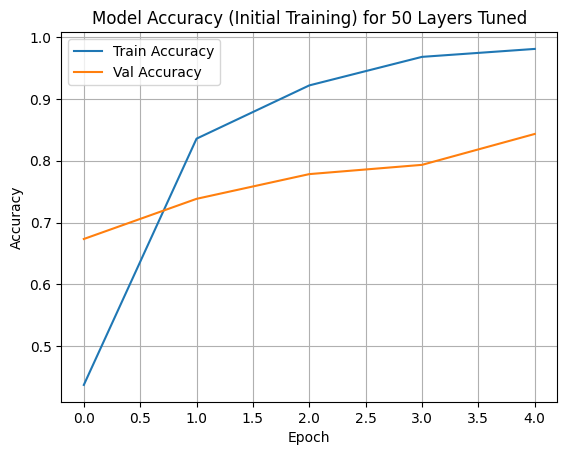

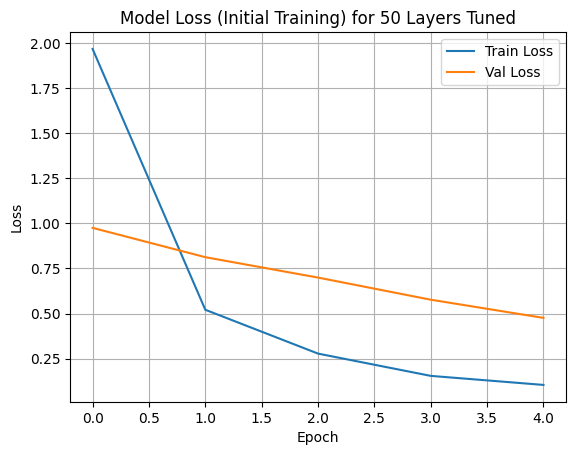

Test Accuracy: 0.84, Test Loss: 0.53
Fine-tuning with layers unfrozen starting at 75...
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 807ms/step - accuracy: 0.3110 - loss: 2.4764 - val_accuracy: 0.5750 - val_loss: 1.6945 - learning_rate: 1.0000e-04
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 568ms/step - accuracy: 0.8380 - loss: 0.5375 - val_accuracy: 0.7317 - val_loss: 0.8558 - learning_rate: 1.0000e-04
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 577ms/step - accuracy: 0.9267 - loss: 0.2647 - val_accuracy: 0.8117 - val_loss: 0.5968 - learning_rate: 1.0000e-04
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 81s 566ms/step - accuracy: 0.9685 - loss: 0.1464 - val_accuracy: 0.8400 - val_loss: 0.4867 - learning_rate: 1.0000e-04
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 594ms/step - accuracy: 0.9743 - loss: 0.1171 - val_accuracy: 0.8550 - val_loss: 0.4951 - learning_rate: 1.0000e-04


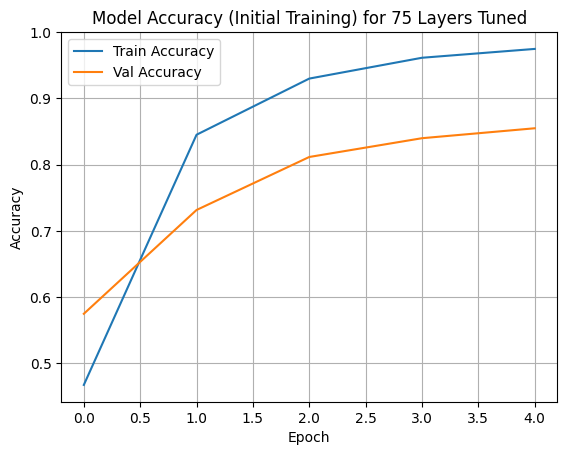

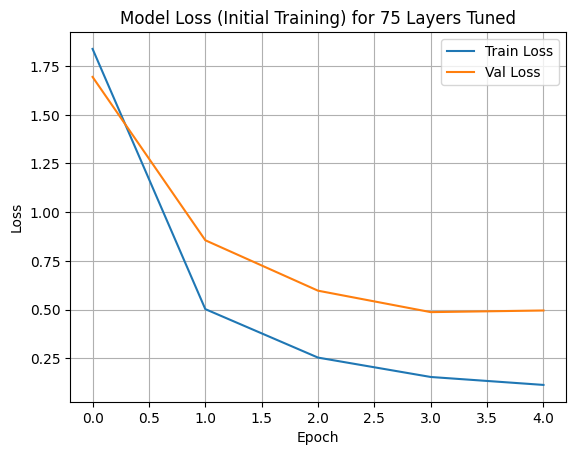

Test Accuracy: 0.85, Test Loss: 0.50
Fine-tuning with layers unfrozen starting at 100...
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 745ms/step - accuracy: 0.2912 - loss: 2.6210 - val_accuracy: 0.6483 - val_loss: 1.1597 - learning_rate: 1.0000e-04
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 591ms/step - accuracy: 0.8401 - loss: 0.5733 - val_accuracy: 0.7417 - val_loss: 0.8453 - learning_rate: 1.0000e-04
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 592ms/step - accuracy: 0.9172 - loss: 0.2998 - val_accuracy: 0.7600 - val_loss: 0.7479 - learning_rate: 1.0000e-04
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 627ms/step - accuracy: 0.9604 - loss: 0.1643 - val_accuracy: 0.7883 - val_loss: 0.6489 - learning_rate: 1.0000e-04
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 591ms/step - accuracy: 0.9677 - loss: 0.1255 - val_accuracy: 0.8150 - val_loss: 0.5577 - learning_rate: 1.0000e-04


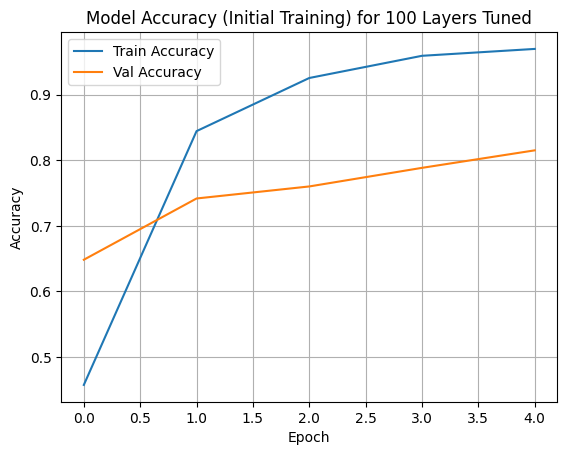

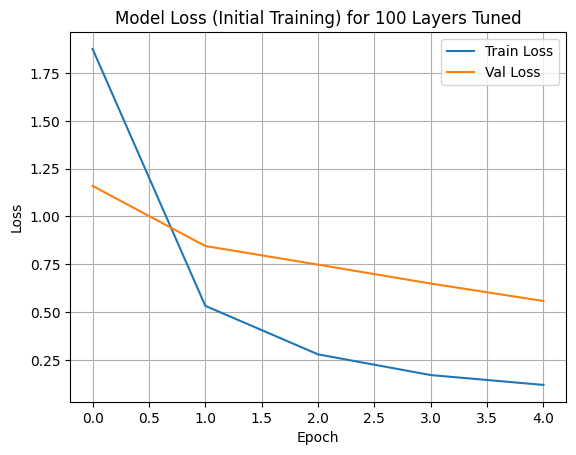

Test Accuracy: 0.81, Test Loss: 0.63
Fine-tuning with layers unfrozen starting at 125...
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 732ms/step - accuracy: 0.3110 - loss: 2.5147 - val_accuracy: 0.6583 - val_loss: 1.0713 - learning_rate: 1.0000e-04
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 577ms/step - accuracy: 0.8271 - loss: 0.5439 - val_accuracy: 0.7417 - val_loss: 0.7496 - learning_rate: 1.0000e-04
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 575ms/step - accuracy: 0.9324 - loss: 0.2593 - val_accuracy: 0.7867 - val_loss: 0.6091 - learning_rate: 1.0000e-04
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 607ms/step - accuracy: 0.9686 - loss: 0.1499 - val_accuracy: 0.8367 - val_loss: 0.5338 - learning_rate: 1.0000e-04
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 81s 577ms/step - accuracy: 0.9736 - loss: 0.1175 - val_accuracy: 0.8433 - val_loss: 0.4957 - learning_rate: 1.0000e-04


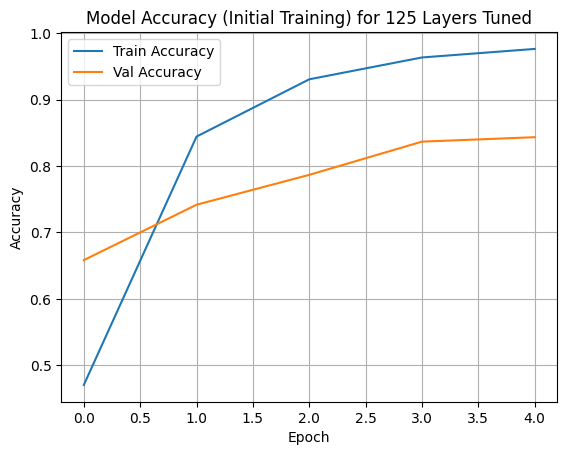

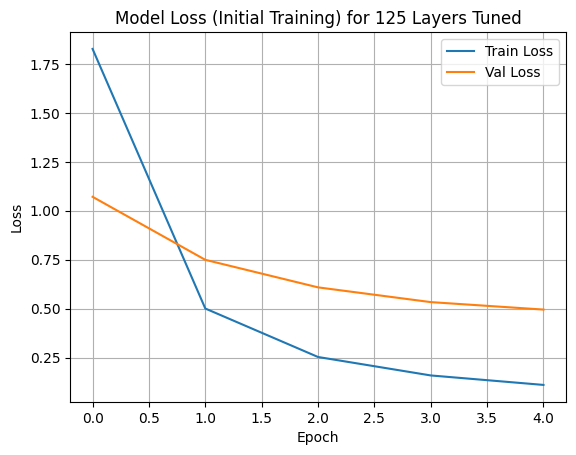

Test Accuracy: 0.84, Test Loss: 0.58
Fine-tuning with layers unfrozen starting at 158...
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 692ms/step - accuracy: 0.3614 - loss: 2.2966 - val_accuracy: 0.7900 - val_loss: 0.6738 - learning_rate: 1.0000e-04
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 723ms/step - accuracy: 0.8283 - loss: 0.5577 - val_accuracy: 0.8367 - val_loss: 0.5004 - learning_rate: 1.0000e-04
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 74s 591ms/step - accuracy: 0.8954 - loss: 0.3510 - val_accuracy: 0.8517 - val_loss: 0.4578 - learning_rate: 1.0000e-04
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 591ms/step - accuracy: 0.9481 - loss: 0.2383 - val_accuracy: 0.8683 - val_loss: 0.4529 - learning_rate: 1.0000e-04
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 572ms/step - accuracy: 0.9684 - loss: 0.1495 - val_accuracy: 0.8800 - val_loss: 0.4221 - learning_rate: 1.0000e-04


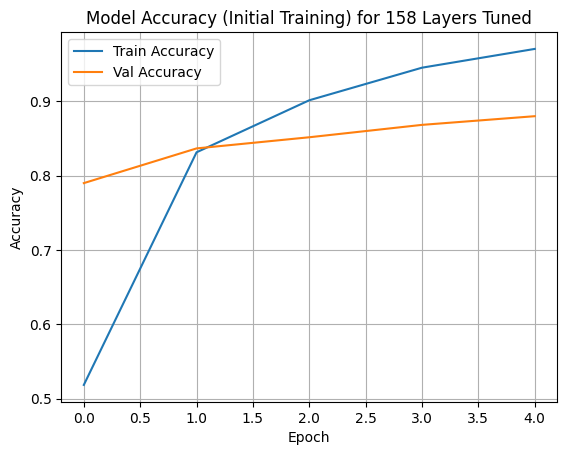

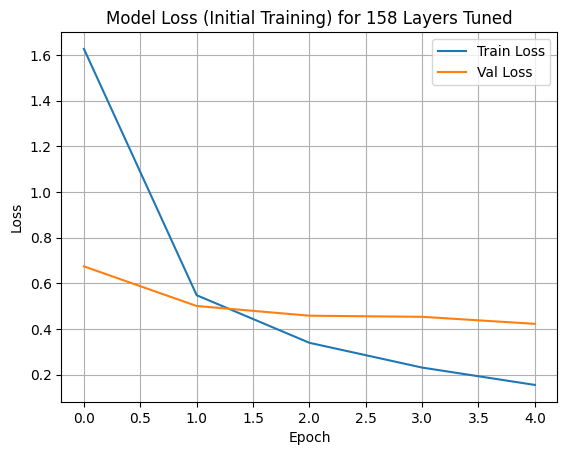

Test Accuracy: 0.86, Test Loss: 0.41
   Layers Unfrozen  Test Loss  Test Accuracy
0               25   0.578189       0.810000
1               50   0.534037       0.843333
2               75   0.500660       0.850000
3              100   0.633128       0.810000
4              125   0.583459       0.836667
5              158   0.407543       0.863333


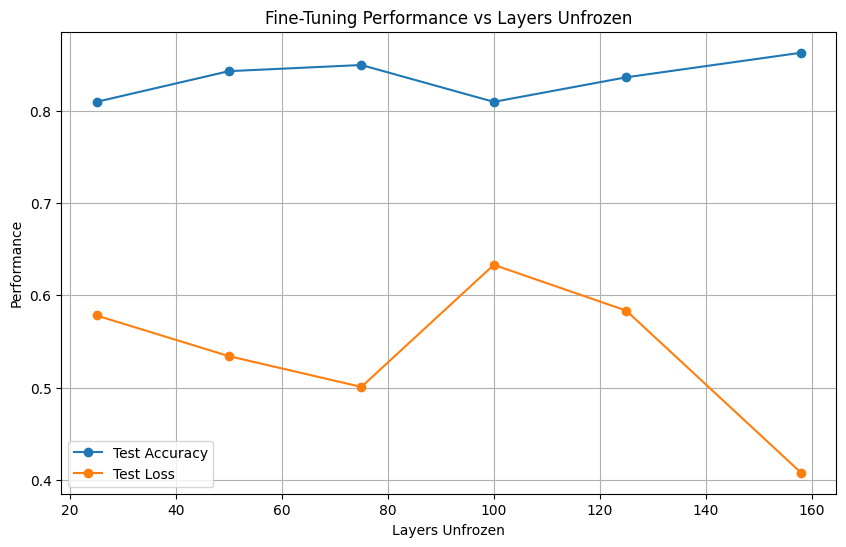

In [ ]:


# Define the range of layers to unfreeze for fine-tuning
fine_tune_layers = [25, 50, 75, 100, 125, 158]  # Example layer indices to test

# Storage for results
fine_tune_results = []

for fine_tune_at in fine_tune_layers:
    print(f"Fine-tuning with layers unfrozen starting at {fine_tune_at}...")

    # Load MobileNetV2 with pre-trained weights
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze base model and freeze specific layers
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Build the transfer learning model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    base_model = Model(inputs, outputs)

    # Re-compile the model
    base_model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate / 10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune the model
    fine_tune_history = base_model.fit(
        train_generator,
        epochs=5,  # Adjust based on your requirements
        validation_data=validation_generator,
        callbacks=[
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        ],
        verbose=1
    )

    plot_model_performance(fine_tune_history, f"{fine_tune_at} Layers Tuned")

    # Evaluate on the test set
    results = base_model.evaluate(test_generator, verbose=0)
    test_loss = results[0]
    test_accuracy = results[1]
    print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

    # Store results
    fine_tune_results.append((fine_tune_at, test_loss, test_accuracy))

# Convert results to a DataFrame for analysis
import pandas as pd
fine_tune_df = pd.DataFrame(fine_tune_results, columns=['Layers Unfrozen', 'Test Loss', 'Test Accuracy'])

# Display the results
print(fine_tune_df)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(fine_tune_df['Layers Unfrozen'], fine_tune_df['Test Accuracy'], marker='o', label='Test Accuracy')
plt.plot(fine_tune_df['Layers Unfrozen'], fine_tune_df['Test Loss'], marker='o', label='Test Loss')
plt.xlabel('Layers Unfrozen')
plt.ylabel('Performance')
plt.title('Fine-Tuning Performance vs Layers Unfrozen')
plt.legend()
plt.grid(True)
plt.show()


### Performance Checkpoint - Architecture Definition and Tuning

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 802ms/step - accuracy: 0.3386 - loss: 2.4132 - val_accuracy: 0.7550 - val_loss: 0.7775 - learning_rate: 1.0000e-04
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 50s 689ms/step - accuracy: 0.8164 - loss: 0.5951 - val_accuracy: 0.8200 - val_loss: 0.5876 - learning_rate: 1.0000e-04
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 720ms/step - accuracy: 0.9042 - loss: 0.3208 - val_accuracy: 0.8383 - val_loss: 0.5088 - learning_rate: 1.0000e-04
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 840ms/step - accuracy: 0.9446 - loss: 0.2159 - val_accuracy: 0.8700 - val_loss: 0.4339 - learning_rate: 1.0000e-04
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 700ms/step - accuracy: 0.9661 - loss: 0.1631 - val_accuracy: 0.8733 - val_loss: 0.4102 - learning_rate: 1.0000e-04
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 851ms/step - accuracy: 0.9744 - loss: 0.1308 - val_accuracy: 0.8717 - val_loss: 0.4124 - learning_rate: 1.0000e-04
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 76s 745ms/step - acc

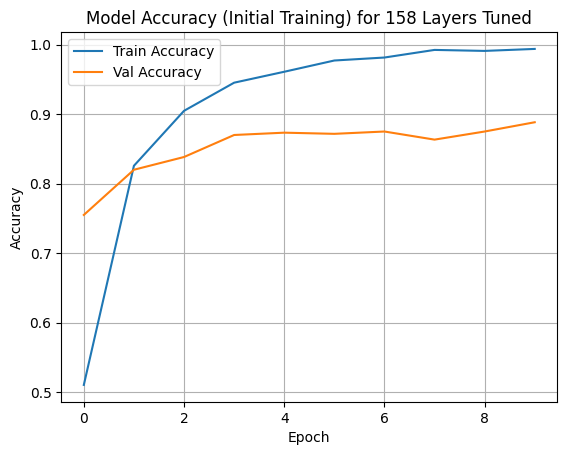

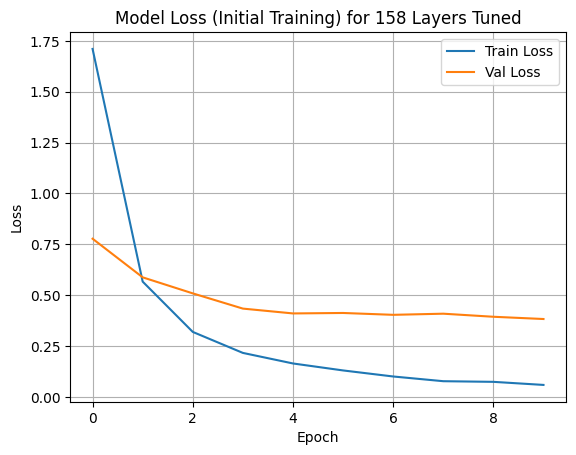

Test Accuracy: 0.88, Test Loss: 0.43


In [ ]:
# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Unfreeze base model and freeze specific layers
base_model.trainable = False

# Build the transfer learning model
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(num_classes, activation='softmax')(x)

base_model = Model(inputs, outputs)

# Re-compile the model
base_model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_history = base_model.fit(
    train_generator,
    epochs=10,  # Adjust based on your requirements
    validation_data=validation_generator,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ],
    verbose=1
)

plot_model_performance(fine_tune_history, f"{fine_tune_at} Layers Tuned")

# Evaluate on the test set
results = base_model.evaluate(test_generator, verbose=0)
test_loss = results[0]
test_accuracy = results[1]
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = base_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 518ms/step - accuracy: 0.8736 - loss: 0.4415
Test Loss: 0.4256
Test Accuracy: 0.8800


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 617ms/step
                           precision    recall  f1-score   support

            american_crow       0.89      1.00      0.94        25
           american_robin       0.88      0.88      0.88        25
     california_scrub_jay       0.85      0.92      0.88        25
        california_towhee       0.84      0.84      0.84        25
chestnut_backed_chickadee       0.92      0.92      0.92        25
          dark_eyed_junco       0.96      1.00      0.98        25
   eurasian_collared_dove       0.79      0.88      0.83        25
             morning_dove       0.86      0.72      0.78        25
             oak_titmouse       0.91      0.80      0.85        25
           pygmy_nuthatch       0.85      0.92      0.88        25
           spotted_towhee       0.84      0.84      0.84        25
             stellers_jay       1.00      0.84      0.91        25

                 accuracy                           0.88       300
                mac

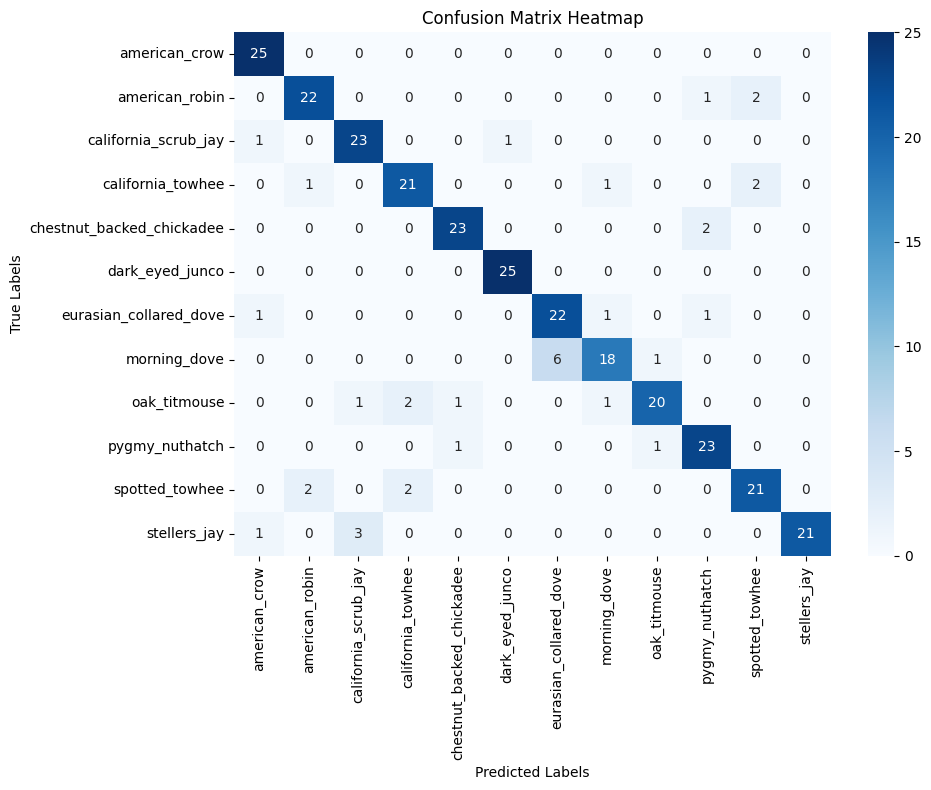

In [ ]:

# Evaluate the model on test data
test_loss, test_accuracy = base_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels
true_labels = test_generator.classes
predicted_probabilities = base_model.predict(test_generator)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Print classification report
target_names = list(test_generator.class_indices.keys())  # Get class names
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
def plot_confusion_matrix_heatmap(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.tight_layout()
    plt.show()

# Class names
class_names = list(test_generator.class_indices.keys())

# Plot the heatmap
plot_confusion_matrix_heatmap(conf_matrix, class_names)

### Grid Search

Training with LR=0.001, Batch Size=16, Dropout Rate=0.3...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training with LR=0.001, Batch Size=16, Dropout Rate=0.5...
Training with LR=0.001, Batch Size=16, Dropout Rate=0.7...
Training with LR=0.001, Batch Size=32, Dropout Rate=0.3...
Training with LR=0.001, Batch Size=32, Dropout Rate=0.5...
Training with LR=0.001, Batch Size=32, Dropout Rate=0.7...
Training with LR=0.001, Batch Size=64, Dropout Rate=0.3...
Training with LR=0.001, Batch Size=64, Dropout Rate=0.5...
Training with LR=0.001, Batch Size=64, Dropout Rate=0.7...
Training with LR=0.01, Batch Size=16, Dropout Rate=0.3...
Training with LR=0.01, Batch Size=16, Dropout Rate=0.5...
Training with LR=0.01, Batch Size=16, Dropout Rate=0.7...
Training with LR=0.01, Batch Size=32, Dropout Rate=0.3...
Training with LR=0.01, Batch Size=32, Dropout Rate=0.5...
Training with LR=0.01, Batch Size=32, Dropout Rate=0.7...
Training with LR=0.01, Batch Size=64, Dropout Rate=0.3...
Training with LR=0.01, Batch Size=64, Dropout Rate=0.5...
Training with LR=0.01, Batch Size=64, Dropout Rate=0.7...
Traini

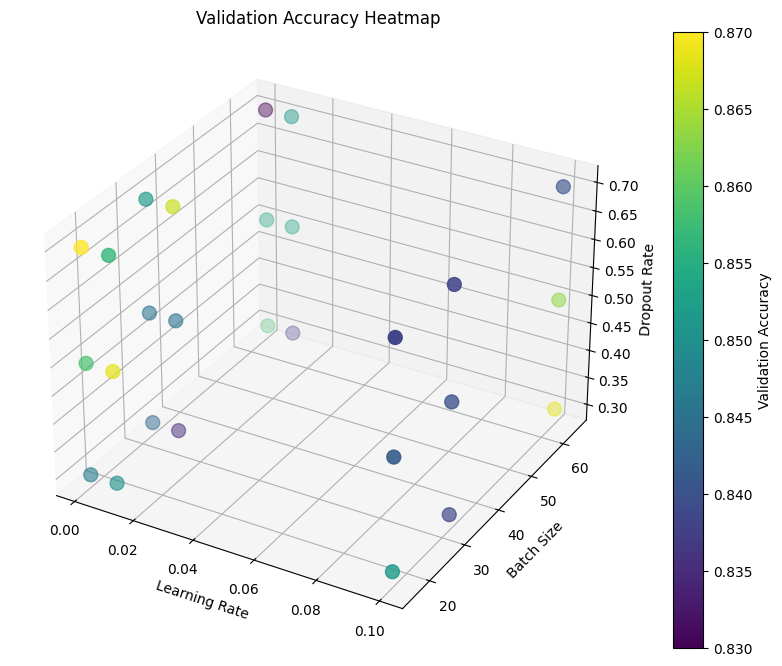

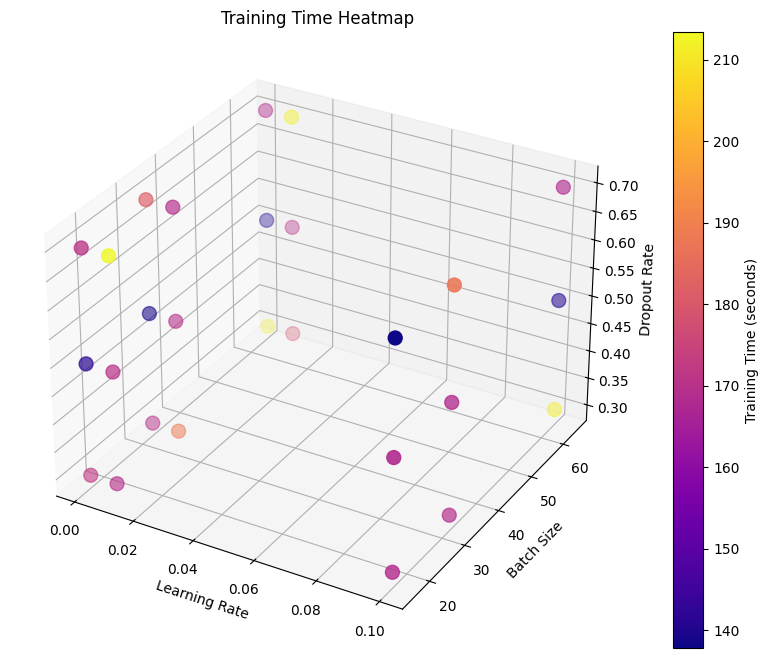

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

# Define parameter grid
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
dropout_rates = [0.3, 0.5, 0.7]

# Storage for results
results = []

# Grid search
for lr in learning_rates:
    for bs in batch_sizes:
        for dr in dropout_rates:
            print(f"Training with LR={lr}, Batch Size={bs}, Dropout Rate={dr}...")

            # Load MobileNetV2 with pre-trained weights
            base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

            # Unfreeze base model and freeze specific layers
            base_model.trainable = False

            # Build the transfer learning model
            inputs = Input(shape=input_shape)
            x = base_model(inputs, training=False)
            x = Flatten()(x)
            x = Dense(128, activation='relu')(x)
            x = BatchNormalization()(x)
            x = Dropout(dropout_rate)(x)
            outputs = Dense(num_classes, activation='softmax')(x)

            base_model = Model(inputs, outputs)

            # Re-compile the model
            base_model.compile(
                optimizer=Adam(learning_rate=initial_learning_rate / 10),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            # Train and record time
            start_time = time.time()
            history = base_model.fit(
                train_generator,
                epochs=3,  # Fewer epochs for coarse search
                batch_size=bs,
                validation_data=validation_generator,
                verbose=0
            )
            end_time = time.time()

            # Record validation accuracy and training time
            val_accuracy = max(history.history['val_accuracy'])
            training_time = end_time - start_time
            results.append((lr, bs, dr, val_accuracy, training_time))

# Convert results to a structured array for visualization
results_array = np.array(results, dtype=[('lr', float), ('bs', int), ('dr', float), ('val_acc', float), ('time', float)])

# Prepare data for plotting
lrs = results_array['lr']
bss = results_array['bs']
drs = results_array['dr']
val_accs = results_array['val_acc']
times = results_array['time']

# Validation Accuracy Heatmap
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(lrs, bss, drs, c=val_accs, cmap='viridis', s=100)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Dropout Rate')
ax.set_title('Validation Accuracy Heatmap')
plt.colorbar(sc, label='Validation Accuracy')
plt.show()

# Training Time Heatmap
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(lrs, bss, drs, c=times, cmap='plasma', s=100)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Dropout Rate')
ax.set_title('Training Time Heatmap')
plt.colorbar(sc, label='Training Time (seconds)')
plt.show()

Best Accuracy Configuration: {'Learning Rate': 0.001, 'Batch Size': 16, 'Dropout Rate': 0.7, 'Validation Accuracy': 0.8700000047683716}
Fastest Training Time Configuration: {'Learning Rate': 0.1, 'Batch Size': 16, 'Dropout Rate': 0.7, 'Training Time': 137.79514503479004}


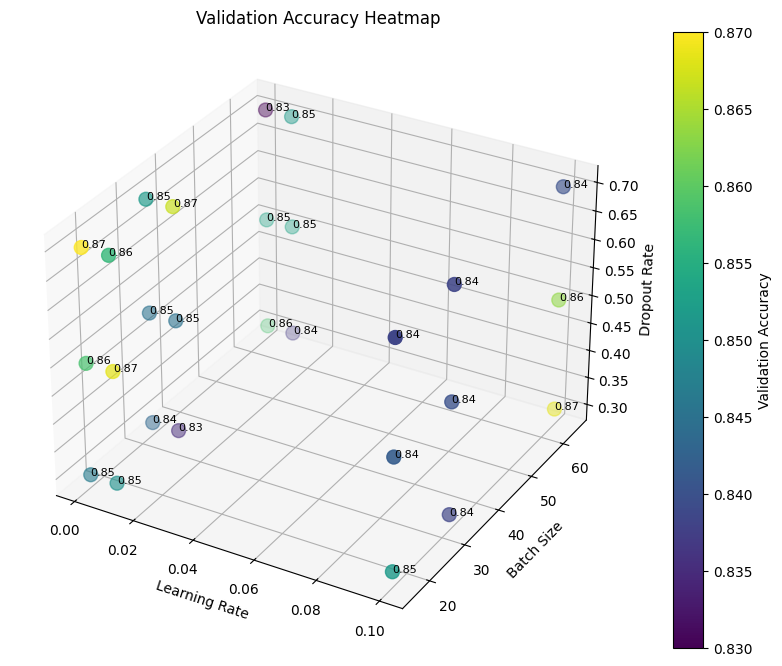

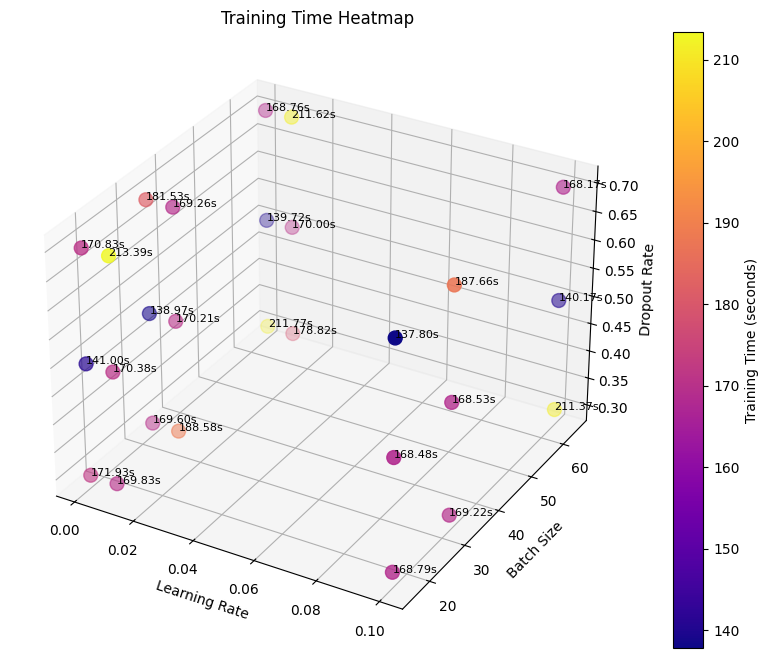

In [ ]:
# Prepare data for plotting
lrs = results_array['lr']
bss = results_array['bs']
drs = results_array['dr']
val_accs = results_array['val_acc']
times = results_array['time']

# Identify best results
best_accuracy_idx = np.argmax(val_accs)
best_time_idx = np.argmin(times)

best_accuracy = {
    "Learning Rate": lrs[best_accuracy_idx],
    "Batch Size": bss[best_accuracy_idx],
    "Dropout Rate": drs[best_accuracy_idx],
    "Validation Accuracy": val_accs[best_accuracy_idx],
}

best_time = {
    "Learning Rate": lrs[best_time_idx],
    "Batch Size": bss[best_time_idx],
    "Dropout Rate": drs[best_time_idx],
    "Training Time": times[best_time_idx],
}

print("Best Accuracy Configuration:", best_accuracy)
print("Fastest Training Time Configuration:", best_time)

# Validation Accuracy Heatmap with data labels
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(lrs, bss, drs, c=val_accs, cmap='viridis', s=100)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Dropout Rate')
ax.set_title('Validation Accuracy Heatmap')
plt.colorbar(sc, label='Validation Accuracy')

# Add data labels
for i in range(len(val_accs)):
    ax.text(lrs[i], bss[i], drs[i], f'{val_accs[i]:.2f}', color='black', fontsize=8)

plt.show()

# Training Time Heatmap with data labels
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(lrs, bss, drs, c=times, cmap='plasma', s=100)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Dropout Rate')
ax.set_title('Training Time Heatmap')
plt.colorbar(sc, label='Training Time (seconds)')

# Add data labels
for i in range(len(times)):
    ax.text(lrs[i], bss[i], drs[i], f'{times[i]:.2f}s', color='black', fontsize=8)

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import random

# Define the objective function for simulated annealing
def evaluate_model(params):
    lr, dr = params

    # Load base model and freeze layers up to fine_tune_at
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    # Build model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        train_generator,
        epochs=3,  # Use fewer epochs for optimization
        batch_size=16,
        validation_data=validation_generator,
        verbose=0
    )

    # Return the validation accuracy
    return max(history.history['val_accuracy'])

# Simulated Annealing
def simulated_annealing(initial_params, n_iterations, cooling_schedule, param_ranges):
    current_params = initial_params
    current_score = evaluate_model(current_params)
    best_params = current_params
    best_score = current_score

    for i in range(n_iterations):
        temperature = cooling_schedule(i)

        # Generate new parameters by perturbing current ones
        new_params = [
            np.clip(current_params[0] + np.random.uniform(-0.001, 0.001), *param_ranges['lr']),  # Learning Rate
            np.clip(current_params[1] + np.random.uniform(-0.1, 0.1), *param_ranges['dr'])     # Dropout Rate
        ]

        # Evaluate the new parameters
        new_score = evaluate_model(new_params)

        # Decide whether to accept the new parameters
        if new_score > current_score or np.exp((new_score - current_score) / temperature) > np.random.rand():
            current_params = new_params
            current_score = new_score

        # Update the best solution
        if new_score > best_score:
            best_params = new_params
            best_score = new_score

        print(f"Iteration {i+1}: Best Score = {best_score:.4f}, Current Score = {current_score:.4f}, Params = {current_params}")

    return best_params, best_score

# Define parameter ranges
param_ranges = {
    'lr': [1e-5, 1e-2],          # Learning Rate
    'dr': [0.5, 0.9],            # Dropout Rate
}

# Cooling schedule (exponential decay)
cooling_schedule = lambda t: max(1e-3, 1.0 / (1 + 0.05 * t))

# Initial parameters
initial_params = [0.001, 0.7]

# Run simulated annealing
best_params, best_score = simulated_annealing(
    initial_params=initial_params,
    n_iterations=20,
    cooling_schedule=cooling_schedule,
    param_ranges=param_ranges
)

print(f"Best Parameters: {best_params}, Best Validation Accuracy: {best_score:.4f}")

Iteration 1: Best Score = 0.8733, Current Score = 0.8650, Params = [0.0018280457193046308, 0.6356203788659016]
Iteration 2: Best Score = 0.8733, Current Score = 0.8483, Params = [0.002607590082248396, 0.6839255935570641]
Iteration 3: Best Score = 0.8733, Current Score = 0.8650, Params = [0.003325154400234686, 0.6224988337257326]
Iteration 4: Best Score = 0.8733, Current Score = 0.8717, Params = [0.0035916329281236825, 0.6758092843477974]
Iteration 5: Best Score = 0.8733, Current Score = 0.8717, Params = [0.0032579698452180977, 0.6241570404755958]
Iteration 6: Best Score = 0.8733, Current Score = 0.8683, Params = [0.003243652929374026, 0.6993196005295919]
Iteration 7: Best Score = 0.8733, Current Score = 0.8683, Params = [0.0032046470555122226, 0.6753425549028498]
Iteration 8: Best Score = 0.8733, Current Score = 0.8683, Params = [0.0027370880619088534, 0.7655329121439614]
Iteration 9: Best Score = 0.8733, Current Score = 0.8683, Params = [0.002026105698310674, 0.7144210493557291]
Itera

## Output

Epoch 1/25
29/66 ━━━━━━━━━━━━━━━━━━━━ 24s 662ms/step - accuracy: 0.3991 - loss: 2.1772

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.5095 - loss: 1.7362

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 75s 898ms/step - accuracy: 0.5135 - loss: 1.7205 - val_accuracy: 0.8000 - val_loss: 0.6518
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 61s 600ms/step - accuracy: 0.8630 - loss: 0.4317 - val_accuracy: 0.8533 - val_loss: 0.4727
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 617ms/step - accuracy: 0.9398 - loss: 0.2311 - val_accuracy: 0.8617 - val_loss: 0.4301
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 625ms/step - accuracy: 0.9729 - loss: 0.1350 - val_accuracy: 0.8817 - val_loss: 0.3946
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 589ms/step - accuracy: 0.9864 - loss: 0.0948 - val_accuracy: 0.8700 - val_loss: 0.3828
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 591ms/step - accuracy: 0.9850 - loss: 0.0863 - val_accuracy: 0.8717 - val_loss: 0.3881
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 604ms/step - accuracy: 0.9852 - loss: 0.0711 - val_accuracy: 0.8733 - val_loss: 0.4080
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 610ms/step - accuracy: 0.9865 - loss: 0.0663 - val_accuracy: 0.881

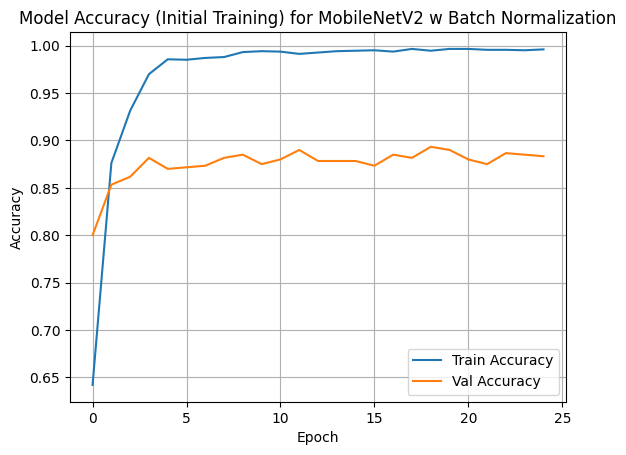

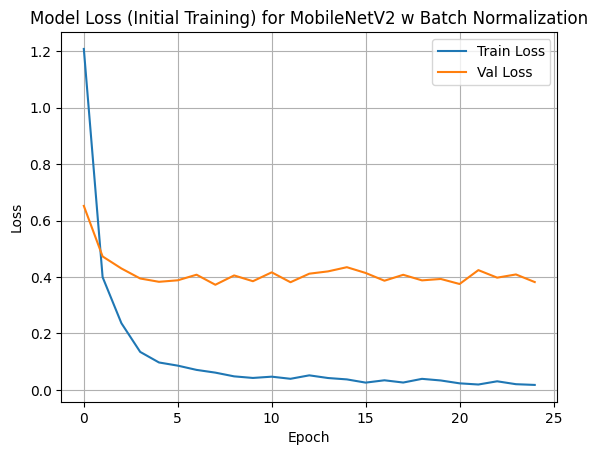

In [23]:

# Load MobileNetV2 with pre-trained weights
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers initially
model.trainable = False

# Build the transfer learning model
inputs = Input(shape=input_shape)
x = model(inputs, training=False)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5775690845396791)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Initial training with frozen base
history = model.fit(
    train_generator,
    epochs=25,
    batch_size=16,
    validation_data=validation_generator
)

# Plot model's performance
plot_model_performance(history, "MobileNetV2 w Batch Normalization")

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 693ms/step - accuracy: 0.8860 - loss: 0.4543
Test Loss: 0.4296
Test Accuracy: 0.8900
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step
                           precision    recall  f1-score   support

            american_crow       0.88      0.92      0.90        25
           american_robin       1.00      0.88      0.94        25
     california_scrub_jay       0.92      0.92      0.92        25
        california_towhee       0.87      0.80      0.83        25
chestnut_backed_chickadee       1.00      0.92      0.96        25
          dark_eyed_junco       0.96      0.96      0.96        25
   eurasian_collared_dove       0.79      0.88      0.83        25
             morning_dove       0.85      0.68      0.76        25
             oak_titmouse       0.81      0.84      0.82        25
           pygmy_nuthatch       0.89      1.00      0.94        25
           spotted_towhee       0.80      0.96      0.87        25
             stellers_jay       0.96   

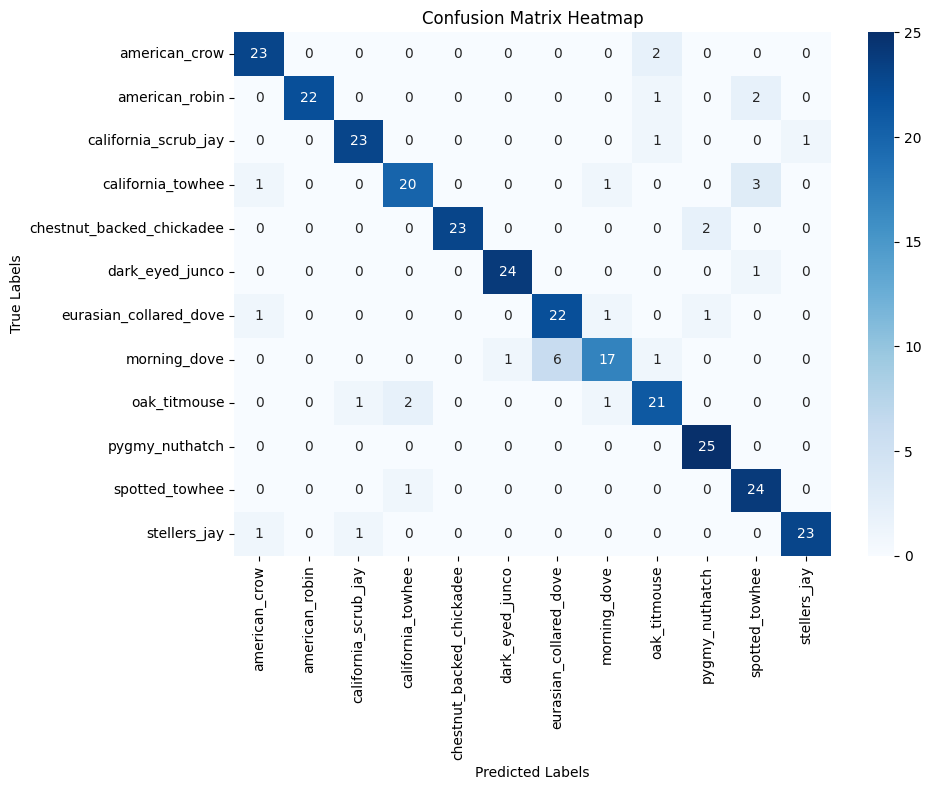

In [26]:

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get true labels and predicted labels
true_labels = test_generator.classes
predicted_probabilities = model.predict(test_generator)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Print classification report
target_names = list(test_generator.class_indices.keys())  # Get class names
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
def plot_confusion_matrix_heatmap(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.tight_layout()
    plt.show()

# Class names
class_names = list(test_generator.class_indices.keys())

# Plot the heatmap
plot_confusion_matrix_heatmap(conf_matrix, class_names)

In [59]:
# Save the model as an HDF5 file
model.save('/content/drive/MyDrive/bird_sensor/model.keras')

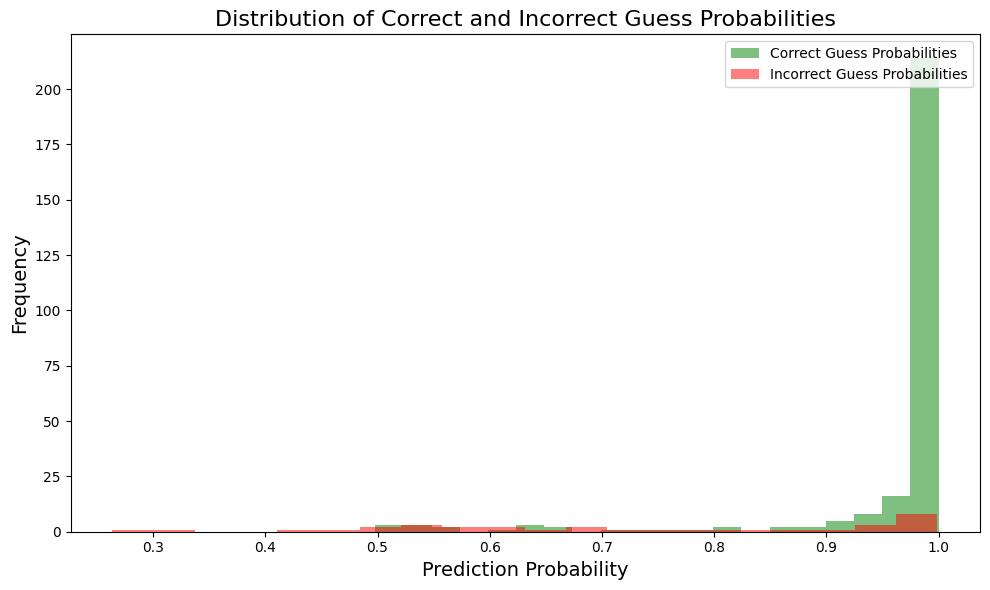

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get the predicted classes (class with the highest probability)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Step 2: Compare predicted and true labels to identify correct and incorrect predictions
correct_predictions = (predicted_classes == true_labels)  # True where prediction is correct
incorrect_predictions = ~correct_predictions  # True where prediction is incorrect

# Step 3: Separate the probabilities of correct and incorrect guesses
correct_probs = [predicted_probabilities[i, true_labels[i]] for i in range(len(predicted_probabilities)) if correct_predictions[i]]

# Use predicted classes for incorrect guesses (predicted label)
incorrect_probs = [predicted_probabilities[i, predicted_classes[i]] for i in range(len(predicted_probabilities)) if incorrect_predictions[i]]

# Convert the lists to arrays for easier handling
correct_probs = np.array(correct_probs)
incorrect_probs = np.array(incorrect_probs)

# Step 4: Plot histograms for correct and incorrect guess probabilities
plt.figure(figsize=(10, 6))

# Histogram for correct guesses
plt.hist(correct_probs, bins=20, alpha=0.5, label='Correct Guess Probabilities', color='green')

# Histogram for incorrect guesses
plt.hist(incorrect_probs, bins=20, alpha=0.5, label='Incorrect Guess Probabilities', color='red')

# Add labels and title
plt.xlabel('Prediction Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Correct and Incorrect Guess Probabilities', fontsize=16)
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [58]:
# Create a dictionary of class numbers and class names
class_indices = train_generator.class_indices
class_dict = {v: k for k, v in class_indices.items()}
class_list = [k for k, v in class_indices.items()]
print(class_list)

# Initialize arrays to store max incorrect label confidence and min correct label confidence
max_incorrect_confidence_per_class = {i: [] for i in range(num_classes)}
min_correct_confidence_per_class = {i: [] for i in range(num_classes)}

# Step 1: Classify and store probabilities for correct and incorrect guesses by class
for i in range(len(predictions)):
    true_class = true_labels[i]
    predicted_class = np.argmax(predictions[i])

    # For correct predictions
    if predicted_class == true_class:
        min_correct_confidence_per_class[true_class].append(predictions[i, true_class])
    # For incorrect predictions
    else:
        max_incorrect_confidence_per_class[true_class].append(predictions[i, predicted_class])

# Step 2: Compute max incorrect confidence and min correct confidence for each class
max_incorrect_confidence_per_class = {k: max(v) if v else np.nan for k, v in max_incorrect_confidence_per_class.items()}
min_correct_confidence_per_class = {k: min(v) if v else np.nan for k, v in min_correct_confidence_per_class.items()}

# Step 3: Create a table
data = {
    'Class': class_list,
    'Max Incorrect Label Confidence': [max_incorrect_confidence_per_class[i] for i in range(num_classes)],
    'Min Correct Label Confidence': [min_correct_confidence_per_class[i] for i in range(num_classes)],
}

df_per_class = pd.DataFrame(data)

# Step 4: Calculate the overall max incorrect and min correct confidence for the whole dataset
overall_max_incorrect = max(max_incorrect_confidence_per_class.values())
overall_min_correct = min(min_correct_confidence_per_class.values())

# Add overall statistics to the table
df_per_class.loc['Overall'] = ['Overall', overall_max_incorrect, overall_min_correct]

# Step 5: Apply conditional styling for text color
def highlight_text_red(row):
    if row['Max Incorrect Label Confidence'] > row['Min Correct Label Confidence']:
        return ['color: red']*len(row)
    return ['']*len(row)

df_styled = df_per_class.style.apply(highlight_text_red, axis=1)

# Display the styled table
df_styled

['american_crow', 'american_robin', 'california_scrub_jay', 'california_towhee', 'chestnut_backed_chickadee', 'dark_eyed_junco', 'eurasian_collared_dove', 'morning_dove', 'oak_titmouse', 'pygmy_nuthatch', 'spotted_towhee', 'stellers_jay']


,Class,Max Incorrect Label Confidence,Min Correct Label Confidence
0,american_crow,0.306060,0.498027
1,american_robin,0.988137,0.819091
2,california_scrub_jay,0.704017,0.513644
3,california_towhee,0.997269,0.543626
4,chestnut_backed_chickadee,0.517067,0.611483
5,dark_eyed_junco,0.748556,0.869700
6,eurasian_collared_dove,0.998658,0.938436
7,morning_dove,0.992979,0.557565
8,oak_titmouse,0.623527,0.628842
9,pygmy_nuthatch,nan,0.558265
